In [5]:
import numpy as np
import pandas as pd
from IPython.display import Image
from IPython.display import display
%config IPCompleter.greedy = True

In [2]:
PATH = '/Users/Eddvibe/Developer/python/ML/pics/'
one=Image(filename = PATH + 'log_loss.png', width=500, height=500)

In [3]:
pwd

'/Users/Eddvibe/Developer/python/ML/boosting'

In [7]:
import os
os.chdir('/Users/Eddvibe/Developer/python/data')

Firstly, we need to specify:

$\bullet$ Loss function

$\bullet$ Base algorithm - $b_t(x_i)$

We will use log loss and decision trees

$L(y,z) = -ylog(z) - (1-y)log(1-z)$ 

$L'=\frac{p-y}{p(1-p)}$

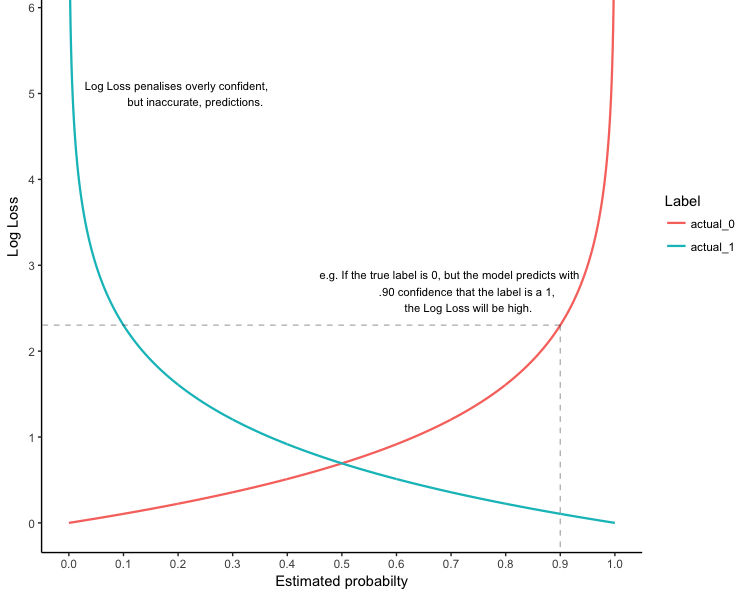

In [5]:
# log loss plot
display(one)

Gradient Boosting algorithm appeared soon after AdaBoost. Because of exponential loss function ($e^{-M}$, where $M$ is margin) AdaBoost is too sensitive to outliers, this was the main motivation to introduce more general Boosting algorithms with arbitrary loss fucntions.

**GBM Algorithm:**

*In*: training sample $X^l$, parameter $T$

*Out*: base algorithms and their weights $\alpha_tb_t$

1.Initialize: $f_i:=0, \space i=1,...,l$

2.for each $t=1,...,T$:

3.find base algorithm approximating gradient:

$\space \space$ $b_t := \arg \min_b \sum_{i=1}^{l}(b(x_i) + L'(f_i, \space y_i))^2$

4.Solve 1-dimensional optimization problem:

$\space \space$ $\alpha_t := \arg \min_{\alpha>0} \sum_{i=1}^{l} L(f_i + \alpha b_t(x_i), \space y_i)$ 

5.Update the result of composition over the training sample:

$\space \space$ $f_i := f_i + \alpha_t b_t(x_i), \space i=1,...,l$

### Importing and preparing data

In [8]:
ds = pd.read_csv('gbm-data.csv')
print(ds.shape)
ds.head()

(3751, 1777)


,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [9]:
ds = ds.values
X = ds[:,1:]
y = ds[:,0]

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=241)

### Building the model

In [14]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

There are **two** optimization problems in one iteration of algorithm: to find $b_t$ and $\alpha_t$

Finding base algorithm approximating gradient:

1. $b_t := \arg \min_b \sum_i^l(b(x_i) + L'(f_i, \space y_i))^2$

In [11]:
def sigmoid(x):
    return 1/(1+np.e**(-x))

In [12]:
def Log_Loss(z, y):
    ll = 0
    if y==0:
        ll = -np.log(1 - sigmoid(z))
    else:
        ll = -np.log(sigmoid(z))
    
    return ll

In [13]:
# vector of pseudo-residuals, i.e. antigradient

def log_loss_grad(p, y):
    
    llg = (p-y)/(p*(1-p))
    
    return -llg

In [14]:
# initialize f_i, i=1,...,l
f = np.ones(len(y_train))/2

llg = log_loss_grad(f, y_train)

In [15]:
DTR = DecisionTreeRegressor(max_depth=3, random_state=241)
DTR.fit(X_train, llg)
y_pred = DTR.predict(X_train)

Solving optimization problem for alpha

2. $\alpha_t := \arg \min_{\alpha>0} \sum_i^l L(f_i + \alpha b_t(x_i), \space y_i)$ 

In [16]:
# log loss as a function of alpha

def L_a(alpha):
    
    # f_i + \alpha b_t(x_i)
    f_ab = f + alpha*y_pred

    log_loss = 0

    for i, y in enumerate(y_train):
        log_loss += Log_Loss(f_ab[i], y_train[i])

    log_loss = log_loss/len(y_train)
    
    return log_loss

Derivative of log loss wrt $\alpha$:

$$\frac{d\big(-ylog(f_i+\alpha b_t(x_i) - (1-y)log(1-f_i-\alpha b_t (x_i))\big)}{d \alpha} = \frac{-y b_t(x_i)}{f_i+\alpha b_t(x_i)} + \frac{(1-y)b_t(x_i)}{1-f_i-\alpha b_t(x_i)}$$

In [17]:
# gradient of L_a, (L_a is a function of alpha)

def log_loss_grad_alpha(alpha):
    f_ab = f + alpha*y_pred
    llga = 0
    for i, y in enumerate(y_train):
        llga += ((1-y)*y_pred[i])/(1-f_ab[i]) - (y*y_pred[i])/f_ab[i]
    
    return llga/len(y_train)

In [18]:
def gradient_descent_alpha(lr, ep, max_iter=10000):
    
    Converged = False
    alpha = 0.01
    iter = 0
    
    # initiale gradient descent
    l_a = L_a(alpha)
    print(l_a)
    
    while not Converged:

        llga = log_loss_grad_alpha(alpha)
        #print(llga)
        alpha_new = alpha - lr * llga 
        l_a_new = L_a(alpha_new)
        print(l_a_new)
        #print('diff', l_a - l_a_new)

        if abs(l_a - l_a_new) < ep:
            print('Converged, iterations:', iter)
            Converged = True
            alpha = alpha_new
            

        iter += 1
        alpha = alpha_new
        l_a = l_a_new
        
        if iter == max_iter:
            print('Max interations exceeded')
            Converged = True
    
    return alpha

In [19]:
gradient_descent_alpha(0.5, 0.05, 500)

0.7133790370542159
0.5614409570350789
0.5298491230726964
Converged, iterations: 1


1.1826423070097496

In [20]:
# Just checking that our gradient descent works properly, by plugging alphas from the set  

alphas_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 1, 1.183, 1.5, 2, 2.5, 3, 3.5, 4, 4.5]
for alpha in alphas_list:
    print(alpha, L_a(alpha))

0.001 0.7164057287076877
0.005 0.7150572860372836
0.01 0.7133790370542159
0.05 0.7002453946138976
0.1 0.6845596510906762
0.25 0.6423676127225364
0.5 0.5879802820331357
1 0.5339425370398806
1.183 0.5298481850776614
1.5 0.5385937081794466
2 0.5833313875126095
2.5 0.6530366410632439
3 0.7375083215508252
3.5 0.8305252489733037
4 0.9284832758773301
4.5 1.029337836169591


Updating the result of composition over the training sample:

$f_i := f_i + \alpha_t b_t(x_i), \space i=1,...,l$

In [21]:
alpha = gradient_descent_alpha(0.5, 0.05, 500)

0.7133790370542159
0.5614409570350789
0.5298491230726964
Converged, iterations: 1


In [22]:
f = f + alpha * y_pred

In [23]:
f_probas = sigmoid(f)

In [24]:
labels = []

for i, value in enumerate(f_probas):
    if value >= 0.5:
        labels.append(1)
    else:
        labels.append(0)

accuracy_score(y_train, labels)

0.776

In [2]:
# Let's compare our result with sklearn result

from sklearn.ensemble import GradientBoostingClassifier

In [46]:
GBC = GradientBoostingClassifier(n_estimators=1, verbose=1, random_state=241)
GBC.fit(X_train, y_train)

y_pred_train = GBC.predict(X_train)

print()
print('accuracy :', accuracy_score(y_train, y_pred_train))

      Iter       Train Loss   Remaining Time 
         1           1.3199            0.00s

accuracy : 0.776


Now let's combine these steps into one algorithm:

In [28]:
# Despite we build our own algorithm for finding optimal alpha on each iteration, 
# it is too sensitive to learning rate and stop criteria parameters, 
# so we better use scipy.optimize

from scipy.optimize import minimize

In [49]:
# Intialize f, every component = 1/2
f = np.ones(len(y_train))/2

# Compute log loss gradient
llg = log_loss_grad(f, y_train)

# Run DTR to found base algorithm
DTR = DecisionTreeRegressor(max_depth=3, random_state=241)
DTR.fit(X_train, llg)
# y_pred - found b_t(x_i)
y_pred = DTR.predict(X_train)

# Finding alpha_t
sol = minimize(L_a, x0 = 0)
alpha_t = sol.x
print('alpha_t :', alpha_t)

# Updating composition
f = f + alpha_t * y_pred
f_probas = sigmoid(f)

# Check accuracy of new composition
labels = []
for i, value in enumerate(f_probas):
    if value >= 0.5:
        labels.append(1)
    else:
        labels.append(0)

print('iter :', 1)
print('accuracy :', accuracy_score(y_train, labels))
print()

for t in range(30):
    
    llg = log_loss_grad(f_probas, y_train)
   
    DTR = DecisionTreeRegressor(max_depth=3, random_state=241)
    DTR.fit(X_train, llg)
    y_pred = DTR.predict(X_train)
    
    sol = minimize(L_a, x0 = 0)
    alpha_t = sol.x
    print('alpha_t :', alpha_t)
   
    f = f + alpha_t * y_pred
    f_probas = sigmoid(f)
    
    labels = []
    for i, value in enumerate(f_probas):
        if value >= 0.5:
            labels.append(1)
        else:
            labels.append(0)
    
    print('iter :', t+2)
    print('accuracy :', accuracy_score(y_train, labels))
    print()

alpha_t : [1.19555012]
iter : 1
accuracy : 0.776

alpha_t : [1.06015854]
iter : 2
accuracy : 0.8013333333333333

alpha_t : [1.12111287]
iter : 3
accuracy : 0.8173333333333334

alpha_t : [1.22189805]
iter : 4
accuracy : 0.8226666666666667

alpha_t : [1.20797465]
iter : 5
accuracy : 0.832

alpha_t : [0.60776447]
iter : 6
accuracy : 0.8253333333333334

alpha_t : [1.21030231]
iter : 7
accuracy : 0.844

alpha_t : [1.27305872]
iter : 8
accuracy : 0.8533333333333334

alpha_t : [0.61842587]
iter : 9
accuracy : 0.852

alpha_t : [2.01147598]
iter : 10
accuracy : 0.8573333333333333

alpha_t : [1.00470717]
iter : 11
accuracy : 0.8653333333333333

alpha_t : [1.44402366]
iter : 12
accuracy : 0.876

alpha_t : [1.16998161]
iter : 13
accuracy : 0.8733333333333333

alpha_t : [0.82895933]
iter : 14
accuracy : 0.8813333333333333

alpha_t : [1.09978443]
iter : 15
accuracy : 0.892

alpha_t : [0.89820152]
iter : 16
accuracy : 0.892

alpha_t : [0.84253436]
iter : 17
accuracy : 0.8853333333333333

alpha_t : [1

Again, let's compare our result with sklearn library

In [16]:
GBC = GradientBoostingClassifier(n_estimators=30, learning_rate=0.2, verbose=1, random_state=241)
GBC.fit(X_train, y_train)

y_pred_train = GBC.predict(X_train)

print()
print('accuracy :', accuracy_score(y_train, y_pred_train))

      Iter       Train Loss   Remaining Time 
         1           1.2613            1.66s
         2           1.1715            1.58s
         3           1.1009            1.53s
         4           1.0529            1.53s
         5           1.0130            1.47s
         6           0.9740            1.40s
         7           0.9475            1.29s
         8           0.9197            1.24s
         9           0.8979            1.19s
        10           0.8730            1.14s
        20           0.7207            0.56s
        30           0.6055            0.00s

accuracy : 0.9106666666666666
